NASA GISS SURFACE TEMPERATURE

# Imports

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.5 MB/s eta 0:00:00


In [ ]:
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 37.6 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [ ]:
from torch import nn
import torch.jit as jit
import torch.nn.functional as F
import numpy as np
from ray import tune

In [ ]:
from datetime import datetime

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
torch.autograd.set_detect_anomaly(True)

# NN classes

## Models and custom cells

In [ ]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        self.model.train()
        yhat = self.model(x)
        loss = self.loss_fn(y, yhat)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                # print("validation start")
                for x_val, y_val in val_loader:
                    # print("validation set", x_val, y_val)
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                # print("validation stop")
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        # torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
      with torch.no_grad():
          predictions = []
          values = []
          for x_test, y_test in test_loader:
              x_test = x_test.view([batch_size, -1, n_features]).to(device)
              y_test = y_test.to(device)
              self.model.eval()
              yhat = self.model(x_test)
              predictions.append(yhat.detach().cpu().numpy())
              values.append(y_test.detach().cpu().numpy())

      return predictions, values

    def evaluateFromArrays(self, X, y, n_features=1):
      X = torch.Tensor(X)
      y = torch.Tensor(y)
      with torch.no_grad():
          prediction = None
          real = None
          x_test = X.view([1, -1, n_features]).to(device)
          y_test = y.to(device)
          self.model.eval()
          yhat = self.model(x_test)
          prediction = yhat.detach().cpu().numpy()
          real = y_test.detach().cpu().numpy()

      return prediction[0], real

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [ ]:
class RNNModel(nn.Module):
    """
    Classic RNN model
    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, h0 = self.rnn(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, _ = self.gru(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)

        return out

ResLSTM

In [ ]:
class ResLSTMLayer(nn.Module):
    """
    For this layer input_dim = hidden_dim = output_dim
    """
    def __init__(self, input_dim, dimension, layer_dim, dropout_prob, batch_first=True):
        super(ResLSTMLayer, self).__init__()
        # print("Creating Residual LSTM", input_dim, dimension, layer_dim, dropout_prob)

        # LSTM layers
        self.lstm = nn.LSTM(input_dim, dimension, layer_dim, batch_first=batch_first, dropout=dropout_prob)
        self.lstm.to(device)

    def forward(self, x, bus):
        # print("forwarding inside residual layer")
        # print(x, h, c)
        h = bus[0]
        c = bus[1]
        out, (hn, cn) = self.lstm(x, (h, c))
        out = out + x

        return [out, (hn, cn)]

In [ ]:
class ResLSTMModel(nn.Module):
    """
    Basic residual LSTM model
    input_dim - dimension of input
    hidden_dim - dimension of hidden layers
    layer_dim - layers count between shortcut connections
    layers_count - count of residual blocks
    output_dim - dimension of output
    dropout_prob - dropout probability on each layer
    """
    def __init__(self, input_dim, hidden_dim, layer_dim, layers_count, output_dim, dropout_prob):
        super(ResLSTMModel, self).__init__()
        print("Creating Residual LSTM model", input_dim, hidden_dim, layer_dim, layers_count, output_dim, dropout_prob)

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.shortcut_layer_dim = layer_dim
        self.layer_dim = layer_dim

        self.layers = []
        reslstm = nn.LSTM(input_dim, hidden_dim, layer_dim, dropout=dropout_prob, batch_first=True)
        reslstm.to(device)
        self.layers.append(reslstm)
        for i in range(layers_count-1):
          reslstm = ResLSTMLayer(hidden_dim, hidden_dim, layer_dim, dropout_prob, batch_first=True)
          reslstm.to(device)
          self.layers.append(reslstm)

        # final lstm layer
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, layer_dim, dropout=dropout_prob, batch_first=True)
        self.lstm.to(device)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        for layer in self.layers:
          # print("forwarding full layer")
          x, bus = layer(x, (h0.detach(), c0.detach()))
          h0, c0 = bus[0], bus[1]
          

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

## Ensembles

Stack creator

In [ ]:
class Stack(nn.Module):
    def __init__(self, models, hidden_dim, output_dim, disable_grad_f):
        super(Stack,self).__init__()
        self.models = list(map(disable_grad_f, models))
        
        self.l_in = nn.Linear(len(self.models)*output_dim, hidden_dim, bias=False)        
        self.l_out = nn.Linear(hidden_dim, output_dim, bias=False)

        print("models count in stack:", len(self.models))
          
    def forward(self,x):
      outputs = []
      for net in self.models: outputs.append(net(x))
      # print(len(outputs), outputs[0].shape)
      out = torch.cat(outputs, 1)
      out1 = F.relu(self.l_in(out))
      out2 = self.l_out(out1)
      return out2

Averaging ensemble

In [ ]:
from functools import reduce

In [ ]:
class SumEnsemble(nn.Module):
    def __init__(self, models, hidden_dim, output_dim, disable_grad_f):
        super(SumEnsemble, self).__init__()
        self.models = list(map(disable_grad_f, models))

        self.l_in = nn.Linear(output_dim, hidden_dim, bias=False)  
        self.l_out = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x):
        outputs = []
        for net in self.models: outputs.append(net(x))
        out = reduce(lambda x, y: x+y, outputs)
        out1 = F.relu(self.l_in(out))
        out2 = self.l_out(out1)
        return out2

# Helper functions

In [ ]:
!mkdir models

In [ ]:
def createDataset(dataset, input_n, horizon):
    X, y, div = [], [], []
    for i in range(len(dataset)-horizon-input_n):
        # print(f"x: {i}:{i+input_n}; y: {i+input_n}:{i+input_n+horizon}")
        feature = dataset.iloc[i:i+input_n]
        target = dataset.iloc[i+input_n:i+input_n+horizon]
        # print(feature, "=>", target)
        div.append(feature.iloc[-1].value)
        # target = target / feature.iloc[-1]
        # feature = feature / feature.iloc[-1]
        X.append(feature["value"].values)
        y.append(target["value"].values)
    X, y = pd.DataFrame(X, columns =[f"I{i}" for i in range(input_n)]), pd.DataFrame(y, columns =[f"H{i}" for i in range(horizon)])
    return (X, y, div)

def train_val_test_split(X, y, val_ratio):
    X_test, y_test = X.iloc[-1], y.iloc[-1]
    X_train, X_val, y_train, y_val = train_test_split(X.iloc[:-1], y.iloc[:-1], test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler=None, concat=None):
    if concat is not None:
      values = np.concatenate(values, axis=concat).ravel()
      predictions = np.concatenate(predictions, axis=concat).ravel()
    df_result = pd.DataFrame(data={"value": values, "prediction": predictions}, index=df_test.head(len(values)).index)
    df_result = df_result.sort_index()
    if scaler is not None: df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

def calculate_metrics(df):
    return{
        'mae' : mean_absolute_error(df.value, df.prediction),
        'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5
    }
            # 'r2' : r2_score(df.value, df.prediction)}

In [ ]:
def scaleData(scaler, X_train, X_val, X_test, y_train, y_val, y_test):
  X_train_arr = scaler.fit_transform(X_train)
  X_val_arr = scaler.transform(X_val)
  X_test_arr = scaler.transform(X_test)

  y_train_arr = scaler.fit_transform(y_train)
  y_val_arr = scaler.transform(y_val)
  y_test_arr = scaler.transform(y_test)
  return (X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr)

In [ ]:
def createTrainers(X_train_arr, y_train_arr, X_val_arr, y_val_arr, batch_size):
  train_features = torch.Tensor(X_train_arr)
  train_targets = torch.Tensor(y_train_arr)
  val_features = torch.Tensor(X_val_arr)
  val_targets = torch.Tensor(y_val_arr)

  train = TensorDataset(train_features, train_targets)
  val = TensorDataset(val_features, val_targets)

  train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
  val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

  return (train_loader, val_loader)

# Data

In [ ]:
!wget https://raw.githubusercontent.com/datasets/global-temp-anomalies/master/data/global-temp-annual.csv -O gistemp.csv

--2023-04-30 17:44:41--  https://raw.githubusercontent.com/datasets/global-temp-anomalies/master/data/global-temp-annual.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5734 (5.6K) [text/plain]
Saving to: ‘gistemp.csv’

gistemp.csv         100%[===================>]   5.60K  --.-KB/s    in 0s      

2023-04-30 17:44:41 (65.6 MB/s) - ‘gistemp.csv’ saved [5734/5734]



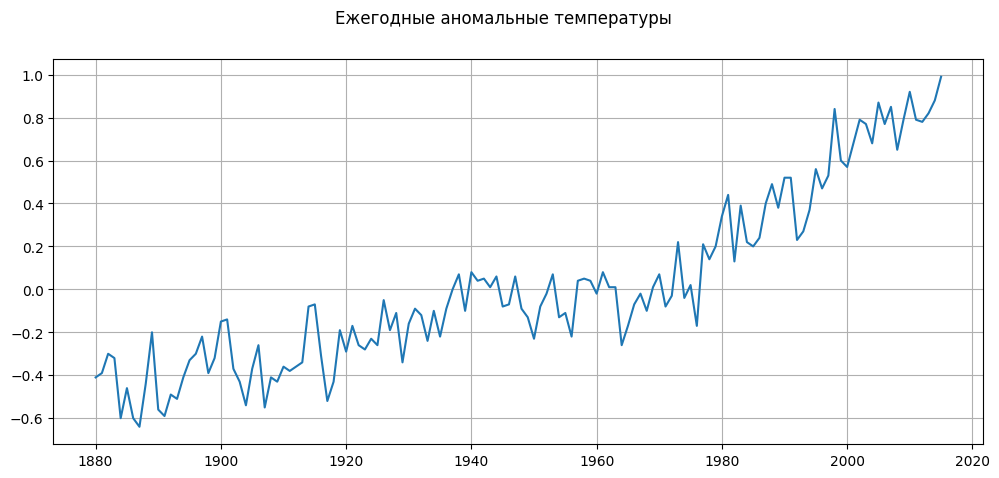

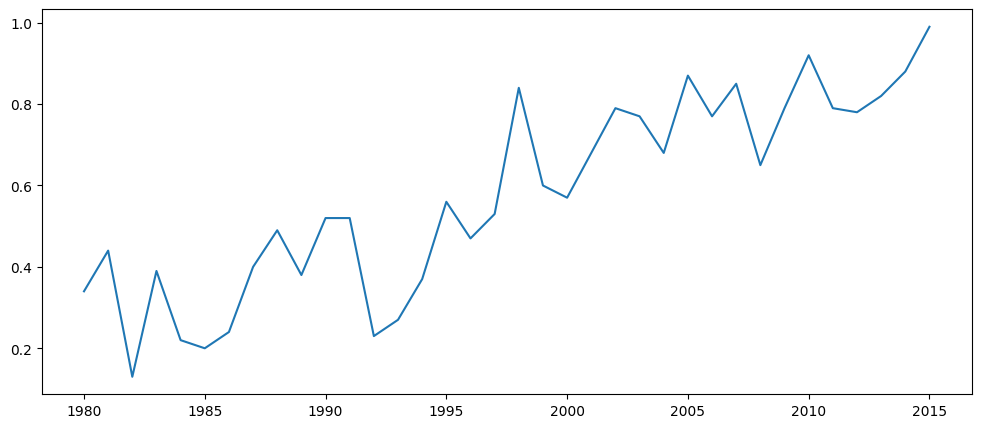

In [ ]:
dohody = pd.read_table('gistemp.csv', delimiter=',')[['Year', 'Land']]
# dohody[0] = pd.date_range(start='1/1993', end= '2/2019', freq = 'M')
dohody = dohody.set_index(['Year'])
dohody = dohody.rename(columns={'Land': 'value'})

plt.figure(figsize=(12, 5))
plt.plot(dohody)
plt.suptitle('Ежегодные аномальные температуры')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(dohody.tail(36))
plt.show()

Lets deseason data

In [ ]:
df = dohody

In [ ]:
# Trend, seasional and residual values
res = STL(df, period = 12).fit()
trend = res.trend
seasonal = res.seasonal
residual = res.resid
deseasoned = trend + residual

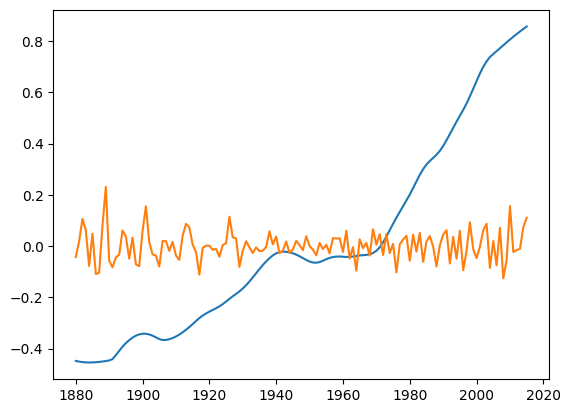

In [ ]:
plt.plot(trend)
plt.plot(seasonal)

Не требуется ввиду изначальной нормализации датасета

In [ ]:
"""
scaler = MinMaxScaler()
scaler.fit(deseasoned.values.reshape(-1, 1))
df = pd.DataFrame(np.transpose([deseasoned.index, scaler.transform(deseasoned.values.reshape(-1, 1)).reshape(313,)]), columns=["Datetime", "value"])
df = df.set_index(['Datetime'])
df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic:
    df = df.sort_index()
"""

'\nscaler = MinMaxScaler()\nscaler.fit(deseasoned.values.reshape(-1, 1))\ndf = pd.DataFrame(np.transpose([deseasoned.index, scaler.transform(deseasoned.values.reshape(-1, 1)).reshape(313,)]), columns=["Datetime", "value"])\ndf = df.set_index([\'Datetime\'])\ndf.index = pd.to_datetime(df.index)\nif not df.index.is_monotonic:\n    df = df.sort_index()\n'

In [ ]:
df["value"]

Year
1880   -0.41
1881   -0.39
1882   -0.30
1883   -0.32
1884   -0.60
        ... 
2011    0.79
2012    0.78
2013    0.82
2014    0.88
2015    0.99
Name: value, Length: 136, dtype: float64

In [ ]:
input_dim = 8
outpur_dim = 4
X, y, div = createDataset(df, input_dim, outpur_dim)

In [ ]:
# X = X.applymap(np.log)
# y = y.applymap(np.log)
X

,I0,I1,I2,I3,I4,I5,I6,I7
0,-0.41,-0.39,-0.30,-0.32,-0.60,-0.46,-0.60,-0.64
1,-0.39,-0.30,-0.32,-0.60,-0.46,-0.60,-0.64,-0.44
2,-0.30,-0.32,-0.60,-0.46,-0.60,-0.64,-0.44,-0.20
3,-0.32,-0.60,-0.46,-0.60,-0.64,-0.44,-0.20,-0.56
4,-0.60,-0.46,-0.60,-0.64,-0.44,-0.20,-0.56,-0.59
...,...,...,...,...,...,...,...,...
119,0.60,0.57,0.68,0.79,0.77,0.68,0.87,0.77
120,0.57,0.68,0.79,0.77,0.68,0.87,0.77,0.85
121,0.68,0.79,0.77,0.68,0.87,0.77,0.85,0.65
122,0.79,0.77,0.68,0.87,0.77,0.85,0.65,0.79


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
print(list(map(len, (X_train, X_val, X_test, y_train, y_val, y_test))))
# scaler = MinMaxScaler()
# X_train_arr, X_val_arr, y_train_arr, y_val_arr = scaleData(scaler, X_train, X_val, y_train, y_val)
# batch_size = 32
# train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

[98, 25, 8, 98, 25, 4]


# ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [ ]:
x_train = df[:-12]

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(x_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q = 3, m = 12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.23 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-50.863, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-81.821, Time=0.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-20.906, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-73.260, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-91.313, Time=1.24 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-58.063, Time=0.82 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-90.875, Time=1.87 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-92.166, Time=8.14 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-80.981, Time=2.08 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=7.73 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


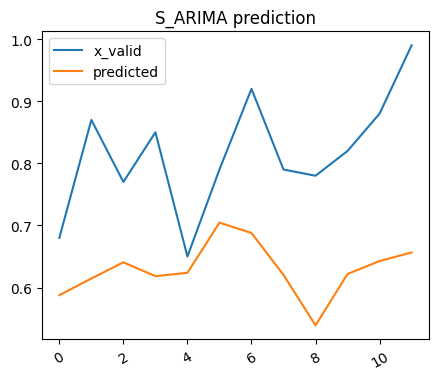

{'mae': 0.1860317348486332, 'rmse': 0.20407184485604485}


In [ ]:
# Forecast
fitted, confint = smodel.predict(12, return_conf_int = True)
fitted = fitted.values
values = df[-12:].values

# make series for plotting purpose
fitted_series = pd.Series(fitted)
lower_series = pd.Series(confint[:, 0])
upper_series = pd.Series(confint[:, 1])

# fitted = scaler.inverse_transform(fitted.values.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
# values = scaler.inverse_transform(df[-12:].values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(fitted, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("S_ARIMA prediction")
plt.show()

print(
    {
        'mae' : mean_absolute_error(values, fitted),
        'rmse' : mean_squared_error(values, fitted) ** 0.5
    }
)

# ETS

In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


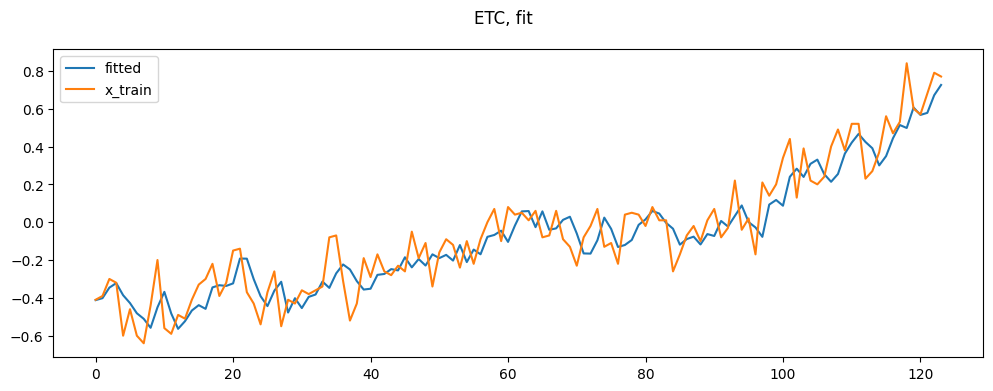

In [ ]:
model = ETSModel(x_train.values.reshape(-1),
                seasonal='add',
                seasonal_periods=12)
fit = model.fit(maxiter = 10)

# spots.plot(label="data")
fitted = fit.fittedvalues

plt.figure(figsize = (12, 4))
plt.plot(fitted, label = 'fitted')
plt.plot(x_train.values.reshape(-1), label = 'x_train')
plt.suptitle('ETC, fit')
plt.legend()
plt.show()



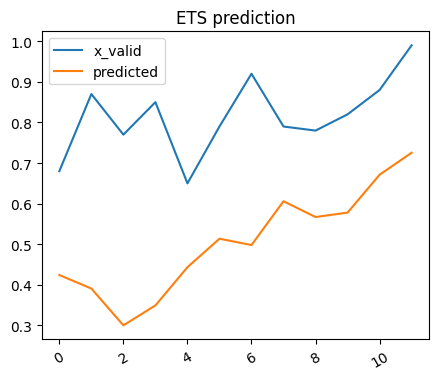

{'mae': 0.31023250702719707, 'rmse': 0.3310240418990833}


In [ ]:
fitted = fit.predict()[-12:]
values = df[-12:].values.reshape(-1, 1) # np.exp(values) # *div[-1]

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(fitted, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ETS prediction")
plt.show()

print(
    {
        'mae' : mean_absolute_error(values, fitted),
        'rmse' : mean_squared_error(values, fitted) ** 0.5
    }
)

# Tuning Basic

## LSTM

[1/24] Training loss: 0.0354	 Validation loss: 0.2542
[2/24] Training loss: 0.0268	 Validation loss: 0.2519
[3/24] Training loss: 0.0226	 Validation loss: 0.1968
[4/24] Training loss: 0.0131	 Validation loss: 0.1407
[5/24] Training loss: 0.0113	 Validation loss: 0.0981
[6/24] Training loss: 0.0111	 Validation loss: 0.0899
[7/24] Training loss: 0.0099	 Validation loss: 0.0616
[8/24] Training loss: 0.0101	 Validation loss: 0.0511
[9/24] Training loss: 0.0100	 Validation loss: 0.0427
[10/24] Training loss: 0.0100	 Validation loss: 0.0493


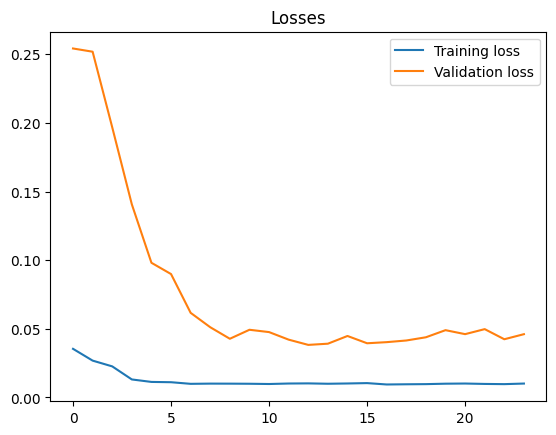

PRED: [0.48573935 0.5060716  0.41731963 0.43195364]
REAL: [0.79 0.78 0.82 0.88]


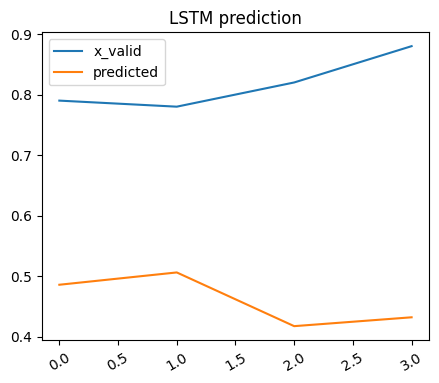

{'mae': 0.35722893, 'rmse': 0.3641799966364212}


In [ ]:
batch_size = 4
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 256
layer_dim = 4
dropout = 0.4
n_epochs = 24
learning_rate = 0.001
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = LSTMModel(**model_params)

# loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

# predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
# values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)
df_result = format_predictions(predictions, values, X_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("LSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

## GRU

[1/24] Training loss: 0.0312	 Validation loss: 0.2450
[2/24] Training loss: 0.0275	 Validation loss: 0.2468
[3/24] Training loss: 0.0230	 Validation loss: 0.1364
[4/24] Training loss: 0.0123	 Validation loss: 0.0854
[5/24] Training loss: 0.0107	 Validation loss: 0.0896
[6/24] Training loss: 0.0121	 Validation loss: 0.0666
[7/24] Training loss: 0.0099	 Validation loss: 0.0556
[8/24] Training loss: 0.0102	 Validation loss: 0.0434
[9/24] Training loss: 0.0102	 Validation loss: 0.0568
[10/24] Training loss: 0.0105	 Validation loss: 0.0455


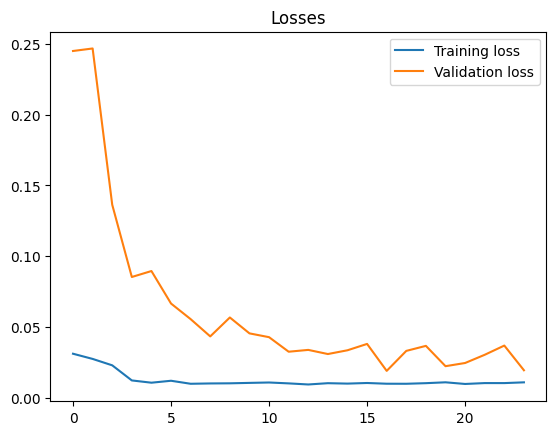

PRED: [0.7381579  0.7596195  0.621309   0.56736517]
REAL: [0.79 0.78 0.82 0.88]


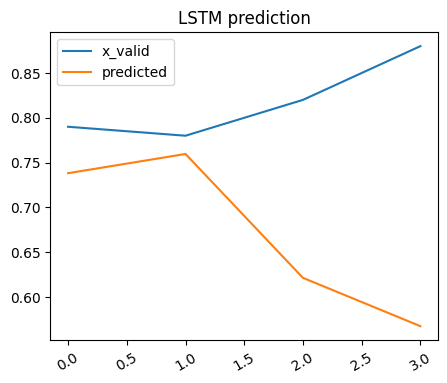

{'mae': 0.1458871, 'rmse': 0.18729763236496963}


In [ ]:
batch_size = 4
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 256
layer_dim = 4
dropout = 0.4
n_epochs = 24
learning_rate = 0.001
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = GRUModel(**model_params)

# loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = nn.HuberLoss(reduction='mean', delta=1.5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

# predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
# values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)
df_result = format_predictions(predictions, values, X_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("LSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

## RNN

[1/24] Training loss: 0.0170	 Validation loss: 0.2348
[2/24] Training loss: 0.0292	 Validation loss: 0.1844
[3/24] Training loss: 0.0364	 Validation loss: 0.2293
[4/24] Training loss: 0.0251	 Validation loss: 0.0998
[5/24] Training loss: 0.0220	 Validation loss: 0.0626
[6/24] Training loss: 0.0112	 Validation loss: 0.0608
[7/24] Training loss: 0.0131	 Validation loss: 0.0648
[8/24] Training loss: 0.0124	 Validation loss: 0.0647
[9/24] Training loss: 0.0115	 Validation loss: 0.0485
[10/24] Training loss: 0.0116	 Validation loss: 0.0610


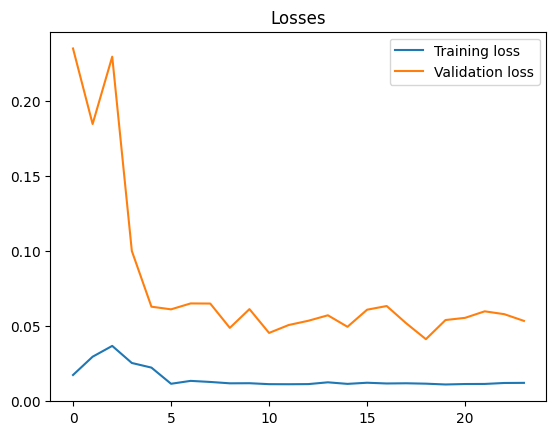

PRED: [0.42795584 0.54703003 0.4550373  0.36538166]
REAL: [0.79 0.78 0.82 0.88]


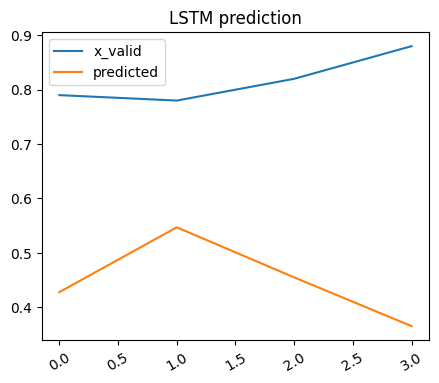

{'mae': 0.36864877, 'rmse': 0.3818968312130776}


In [ ]:
batch_size = 4
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 256
layer_dim = 4
dropout = 0.4
n_epochs = 24
learning_rate = 0.001
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(**model_params)

# loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

# predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
# values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)
df_result = format_predictions(predictions, values, X_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("LSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

## Residual LSTM

Creating Residual LSTM model 8 256 1 6 4 0.4
Creating Residual LSTM 256 256 1 0.4
Creating Residual LSTM 256 256 1 0.4
Creating Residual LSTM 256 256 1 0.4
Creating Residual LSTM 256 256 1 0.4
Creating Residual LSTM 256 256 1 0.4
[1/24] Training loss: 0.0685	 Validation loss: 0.4823
[2/24] Training loss: 0.0459	 Validation loss: 0.4280
[3/24] Training loss: 0.0421	 Validation loss: 0.3700
[4/24] Training loss: 0.0345	 Validation loss: 0.2739
[5/24] Training loss: 0.0280	 Validation loss: 0.1576
[6/24] Training loss: 0.0222	 Validation loss: 0.0700
[7/24] Training loss: 0.0212	 Validation loss: 0.0565
[8/24] Training loss: 0.0217	 Validation loss: 0.0771
[9/24] Training loss: 0.0193	 Validation loss: 0.0732
[10/24] Training loss: 0.0194	 Validation loss: 0.0576


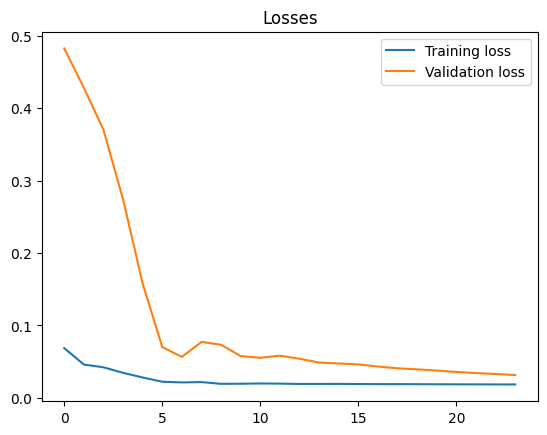

PRED: [0.7856227  0.7504583  0.74704987 0.72437066]
REAL: [0.79 0.78 0.82 0.88]
{'mae': 0.06562461, 'rmse': 0.08722683531107353}


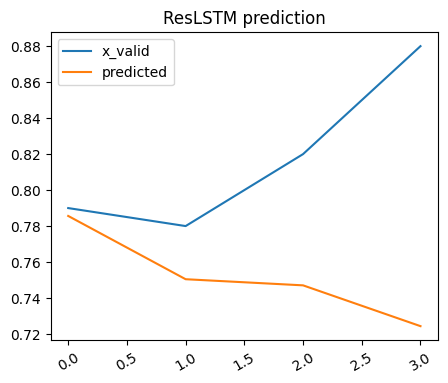

{'mae': 0.06562461, 'rmse': 0.08722683531107353}


In [ ]:
batch_size = 4
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 256
layer_dim = 1
layers_count = 6
dropout = 0.4
n_epochs = 24
learning_rate = 0.001
weight_decay = 1e-6
# input_dim, hidden_dim, shortcut_layer_dim, layers_count, output_dim, dropout_prob

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                "layers_count" : layers_count, 
                'output_dim' : output_dim,
                'dropout_prob' : dropout
                }

model = ResLSTMModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.HuberLoss(delta=1.1)
# loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)
# predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
# values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)

df_result = format_predictions(predictions, values, X_test, None)
result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ResLSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Ensembles

In [ ]:
batch_size = 16
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

## Residual LSTM

In [ ]:
# X, y, div = createDataset(df, 24, output_dim)
# X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
batch_size = 4
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 256
layer_dim = 1
layers_count = 6
dropout = 0.4
n_epochs = 24
learning_rate = 0.001
weight_decay = 1e-6

loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
models = []
layer_props = (96, 1, 4)
for i in range(10):
  hidden_dim, layer_dim, layers_count = layer_props
  model_params = {
    'input_dim': input_dim,
    'hidden_dim' : hidden_dim,
    'layer_dim' : layer_dim,
    "layers_count" : layers_count, 
    'output_dim' : output_dim,
    'dropout_prob' : dropout
  }
  model = ResLSTMModel(**model_params)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
  models.append(opt)
  print(f"Trained model with h={hidden_dim} l={layer_dim}")

Creating Residual LSTM model 8 96 1 4 4 0.4
Creating Residual LSTM 96 96 1 0.4
Creating Residual LSTM 96 96 1 0.4
Creating Residual LSTM 96 96 1 0.4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/24] Training loss: 0.0603	 Validation loss: 0.5576
[2/24] Training loss: 0.0461	 Validation loss: 0.5174
[3/24] Training loss: 0.0440	 Validation loss: 0.4797
[4/24] Training loss: 0.0415	 Validation loss: 0.4328
[5/24] Training loss: 0.0377	 Validation loss: 0.3656
[6/24] Training loss: 0.0328	 Validation loss: 0.2747
[7/24] Training loss: 0.0272	 Validation loss: 0.1738
[8/24] Training loss: 0.0223	 Validation loss: 0.0962
[9/24] Training loss: 0.0199	 Validation loss: 0.0627
[10/24] Training loss: 0.0196	 Validation loss: 0.0573
Trained model with h=96 l=1
Creating Residual LSTM model 8 96 1 4 4 0.4
Creating Residual LSTM 96 96 1 0.4
Creating Residual LSTM 96 96 1 0.4
Creating Residual LSTM 96 96 1 0.4
[1/24] Training loss: 0.0608	 Validation loss: 0.5427
[2/24] Training loss: 0.0470	 Validation loss: 0.5212
[3/24] Training loss: 0.0442	 Validation loss: 0.4895
[4/24] Training loss: 0.0419	 Validation loss: 0.4506
[5/24] Training loss: 0.0389	 Validation loss: 0.3978
[6/24] Train

models count in stack: 10
[1/12] Training loss: 0.0611	 Validation loss: 0.4116
[2/12] Training loss: 0.0410	 Validation loss: 0.3385
[3/12] Training loss: 0.0295	 Validation loss: 0.2766
[4/12] Training loss: 0.0230	 Validation loss: 0.2247
[5/12] Training loss: 0.0200	 Validation loss: 0.1810
[6/12] Training loss: 0.0188	 Validation loss: 0.1445
[7/12] Training loss: 0.0184	 Validation loss: 0.1141
[8/12] Training loss: 0.0182	 Validation loss: 0.0893
[9/12] Training loss: 0.0180	 Validation loss: 0.0693
[10/12] Training loss: 0.0179	 Validation loss: 0.0536


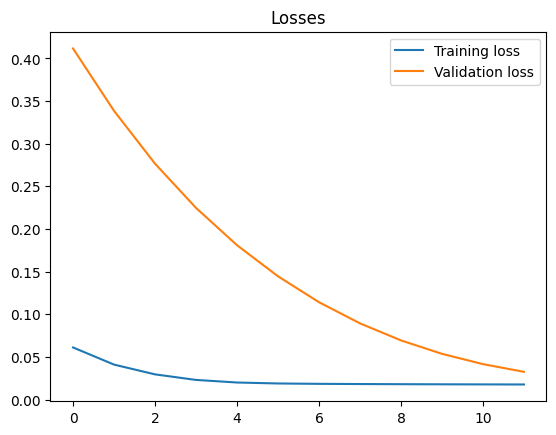

PRED: [0.64514154 0.63825715 0.79504347 0.8113169 ]
REAL: [0.79 0.78 0.82 0.88]
{'mae': 0.09506023, 'rmse': 0.10772093844701461}


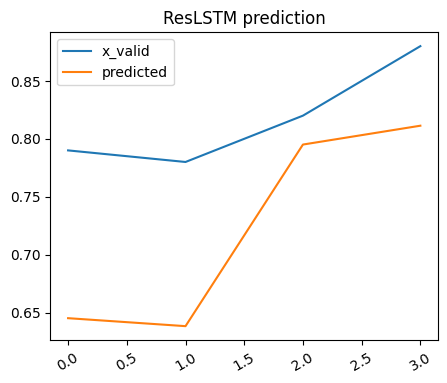

In [ ]:
def disable_grad(layer):
    for _layer in layer.layers:
      for p in _layer.parameters():
          p.requires_grad=False
    for p in layer.parameters():
          p.requires_grad=False
    return layer

learning_rate = 0.0001
model = Stack(list(map(lambda x: x.model, models)), 512, output_dim, disable_grad)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=12, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)
# predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
# values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)

df_result = format_predictions(predictions, values, X_test, None)
result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ResLSTM prediction")
plt.show()

## Basic LSTM

In [ ]:
# X, y, div = createDataset(df, 36, output_dim)
# X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
batch_size = 4
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 256
layer_dim = 4
dropout = 0.4
n_epochs = 24
learning_rate = 0.001
weight_decay = 1e-6

loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
models = []
layer_props = (96, 3, 3)
for i in range(8):
  hidden_dim, layer_dim, layers_count = layer_props
  model_params = {
    'input_dim': input_dim,
    'hidden_dim' : hidden_dim,
    'layer_dim' : layer_dim,
    # "layers_count" : layers_count, 
    'output_dim' : output_dim,
    'dropout_prob' : dropout
  }
  model = LSTMModel(**model_params)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
  models.append(opt)
  print(f"Trained model with h={hidden_dim} l={layer_dim}")

[1/24] Training loss: 0.0311	 Validation loss: 0.2614
[2/24] Training loss: 0.0258	 Validation loss: 0.2697
[3/24] Training loss: 0.0236	 Validation loss: 0.2602
[4/24] Training loss: 0.0211	 Validation loss: 0.2378
[5/24] Training loss: 0.0171	 Validation loss: 0.2069
[6/24] Training loss: 0.0133	 Validation loss: 0.1767
[7/24] Training loss: 0.0108	 Validation loss: 0.1464
[8/24] Training loss: 0.0113	 Validation loss: 0.1326
[9/24] Training loss: 0.0109	 Validation loss: 0.1198
[10/24] Training loss: 0.0105	 Validation loss: 0.1099
Trained model with h=96 l=3
[1/24] Training loss: 0.0298	 Validation loss: 0.2677
[2/24] Training loss: 0.0251	 Validation loss: 0.2723
[3/24] Training loss: 0.0233	 Validation loss: 0.2602
[4/24] Training loss: 0.0205	 Validation loss: 0.2292
[5/24] Training loss: 0.0155	 Validation loss: 0.1826
[6/24] Training loss: 0.0109	 Validation loss: 0.1472
[7/24] Training loss: 0.0106	 Validation loss: 0.1188
[8/24] Training loss: 0.0108	 Validation loss: 0.1109

models count in stack: 8
[1/8] Training loss: 0.0794	 Validation loss: 0.3949
[2/8] Training loss: 0.0281	 Validation loss: 0.2599
[3/8] Training loss: 0.0186	 Validation loss: 0.1703
[4/8] Training loss: 0.0179	 Validation loss: 0.1125
[5/8] Training loss: 0.0176	 Validation loss: 0.0767
[6/8] Training loss: 0.0176	 Validation loss: 0.0565
[7/8] Training loss: 0.0175	 Validation loss: 0.0457
[8/8] Training loss: 0.0175	 Validation loss: 0.0402


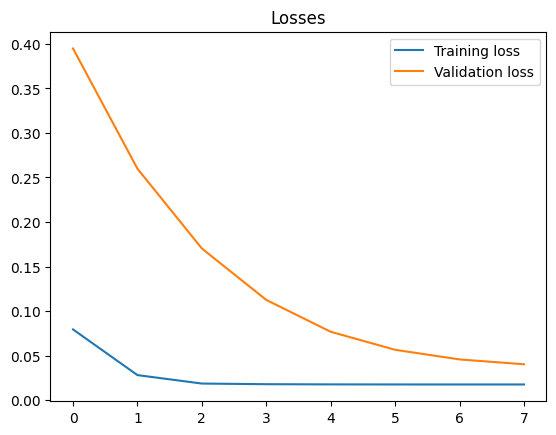

PRED: [0.6179201  0.6096362  0.54912895 0.6270075 ]
REAL: [0.79 0.78 0.82 0.88]
{'mae': 0.21657681, 'rmse': 0.22136601341559534}


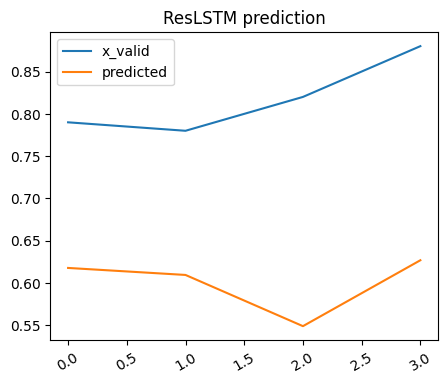

In [ ]:
def disable_grad(layer):
    for p in layer.parameters():
          p.requires_grad=False
    return layer

learning_rate = 0.0003
model = Stack(list(map(lambda x: x.model, models)), 512, output_dim, disable_grad)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=8, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)
# predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
# values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)

df_result = format_predictions(predictions, values, X_test, None)
result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ResLSTM prediction")
plt.show()

# Summary

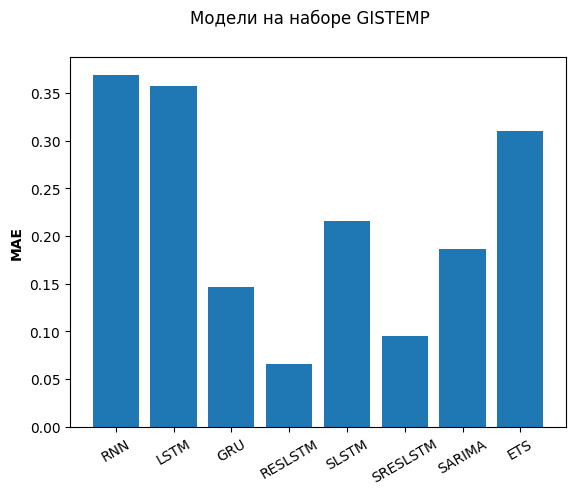

In [ ]:
yt = [ 0.369,  0.357, 0.146, 0.066, 0.216, 0.095, 0.186, 0.310]

xt = [r for r in range(len(yt))]

xlabels =  ['RNN', 'LSTM', 'GRU', 'RESLSTM', 'SLSTM', 'SRESLSTM', 'SARIMA', 'ETS']

plt.bar(xt, yt)
plt.xticks(xt, xlabels[: len(yt)])
plt.ylabel('MAE', fontweight ='bold')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.suptitle('Модели на наборе GISTEMP')

plt.show()